# Thresholding Group Analyses

*Written by Luke Chang*

_Modified by JD Knotts for Spring 2022_

Now that we have learned how to estimate a single-subject model, create contrasts, and run a group-level analysis, the next important topic to cover is how we can threshold these group maps. This is not as straightforward as it might seem as we need to be able to correct for multiple comparisons.

In this tutorial, we will cover how we go from modeling brain responses in each voxel for a single participant to making inferences about the group. We will cover the following topics:

- Issues with correcting for multiple comparisons
- Family Wise Error Rate
- Bonferroni Correction
- False Discovery Rate

Let's get started by watching an overview of multiple comparisons by Martin Lindquist.

In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo('AalIM9-5-Pk')

The primary goal in fMRI data analysis is to make inferences about how the brain processes information. These inferences can be in the form of predictions, but most often we are testing hypotheses about whether a particular region of the brain is involved in a specific type of process. This requires rejecting a $H_0$ hypothesis (i.e., that there is no effect). Null hypothesis testing is traditionally performed by specifying contrasts between different conditions of an experimental design and assessing if these differences between conditions are reliably present across many participants. There are two main types of errors in null-hypothesis testing.

*Type I error*
- $H_0$ is true, but we mistakenly reject it (i.e., False Positive)
- This is controlled by significance level $\alpha$.

*Type II error*
- $H_0$ is false, but we fail to reject it (False Negative)

The probability that a hypothesis test will correctly reject a false null hypothesis is described as the *power* of the test.

Hypothesis testing in fMRI is complicated by the fact that we are running many tests across each voxel in the brain (hundreds of thousands of tests). Selecting an appropriate threshold requires finding a balance between sensitivity (i.e., true positive rate) and specificity (i.e., false negative rate). There are two main approaches to correcting for multiple tests in fMRI data analysis. 

**Familywise Error Rate** (FWER) attempts to control the probability of finding *at least one* false positive. Mathematically, FWER can be defined as the probability $P$ of observing any false positive ${FWER} = P({number Of False Positives}\geq 1)$.

While, **False Discovery Rate** (FDR) attempts to control the proportion of false positives among rejected tests. Formally, this is the expected ratio of false positives to the observed number of significant tests ${FDR} = E(\frac{False Positives}{Significant Tests})$.

This should probably be no surprise to anyone, but fMRI studies are expensive and inherently underpowered. Here is a simulation by Jeannette Mumford to show approximately how many participants you would need to achieve 80% power assuming a specific effect size in your contrast.

![fmri_power.png](../images/thresholding/fmri_power.png)



## Simulations

Let's explore the concept of false positives to get an intuition about what the overall goals and issues are in controlling for multiple tests.

Let's load the modules we need for this tutorial. We will be using the SimulateGrid class which contains everything we need to run all of the simulations.

In [ ]:
%matplotlib inline

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools.data import Brain_Data
from nltools.simulator import SimulateGrid


Okay, let's get started and generate 100 x 100 voxels from $\mathcal{N}(0,1)$ distribution for 20 independent participants. 

In [ ]:
simulation = SimulateGrid(grid_width=100, n_subjects=20)

f,a = plt.subplots(nrows=5, ncols=4, figsize=(15,15), sharex=True, sharey=True)
counter = 0
for col in range(4):
    for row in range(5):
        sns.heatmap(simulation.data[:, :, counter], ax=a[row, col], cmap='RdBu_r', vmin=-4, vmax=4)
        a[row,col].set_title(f'Subject {counter+1}', fontsize=16)
        counter += 1
plt.tight_layout()

Each subject's simulated data is on a 100 x 100 grid. Think of this as a slice from their brain, where each pixel corresponds to the same spatial location across all participants. We have generated random noise separately for each subject. We have not added any true signal in this simulation yet.

This figure is simply to highlight that we are working with 20 independent subjects. In the rest of the plots, we will be working with a single grid that aggregates the results across participants.

Now we are going to start running some simulations to get a sense of the number of false positives we might expect to observe with this data. We will now run an independent one-sample t-test on every pixel in the grid across all 20 participants. The null hypothesis for each test is that the mean signal in the given voxel is zero.

Text(0.5, 1.0, 'T Values')

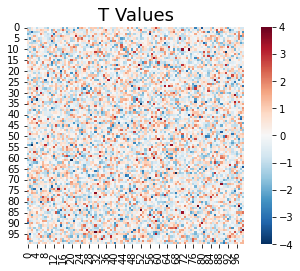

In [6]:
simulation.fit()

sns.heatmap(simulation.t_values, square=True, cmap='RdBu_r', vmin=-4, vmax=4)
plt.title("T Values", fontsize=18)

Even though there was no signal in this simulation, you can see that there are a number of pixels in the grid with t-values that are greater than +2 or less than -2, which are the approximate cutoffs for p < 0.05. Thus, assuming an alpha threshold of approximately 0.05, these are all false positives.

So let's apply a threshold. We can specify thresholds at a specific t-value using the `threshold_type='t'`. Alternatively, we can specify a specific p-value using the `threshold_type='p'`. To calculate the number of false positives, we can simply count the number of tests that exceed this threshold.

If we run this simulation again 100 times (we will refer to each iteration as a separate **experiment**), we can estimate the false positive rate by finding the proportion of experiments in which at least one false positive was observed.

Let's see what this looks like for a threshold of p < 0.05.

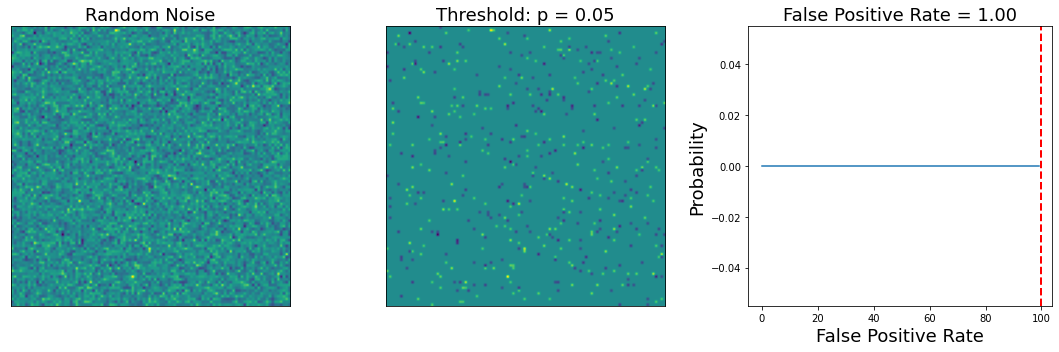

In [7]:
threshold = .05
simulation = SimulateGrid(grid_width=100, n_subjects=20)
simulation.plot_grid_simulation(threshold=threshold, threshold_type='p', n_simulations=100)

The left panel shows the average t-values over all of the participants in a single experiment. The middle panel shows voxels that exceed the statistical threshold in that experiment. The right panel is the overall false-positive rate across the 100 experiments.

In this simulation, a threshold of p < 0.05 results in observing at least one voxel that is a false positive across every one of our 100 experiments.

What if we looked at a lower number of voxels? How would this change our false positive rate?

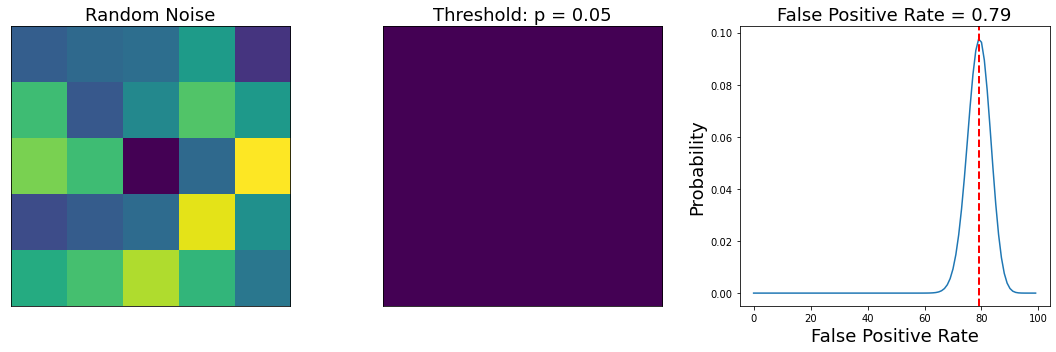

In [8]:
threshold = .05
simulation = SimulateGrid(grid_width=5, n_subjects=20)
simulation.plot_grid_simulation(threshold=threshold, threshold_type='p', n_simulations=100)

This simulation shows that examining fewer voxels will yield considerably fewer false positives. One common approach to controlling for multiple tests involves only looking for voxels within a specific region of interest (e.g., small volume correction), or looking at average activation within a larger region (e.g., ROI based analyses).

What if, instead of changing the number of voxels, we change the threshold on our original 100 x 100 grid? Let's make the alpha threshold smaller.

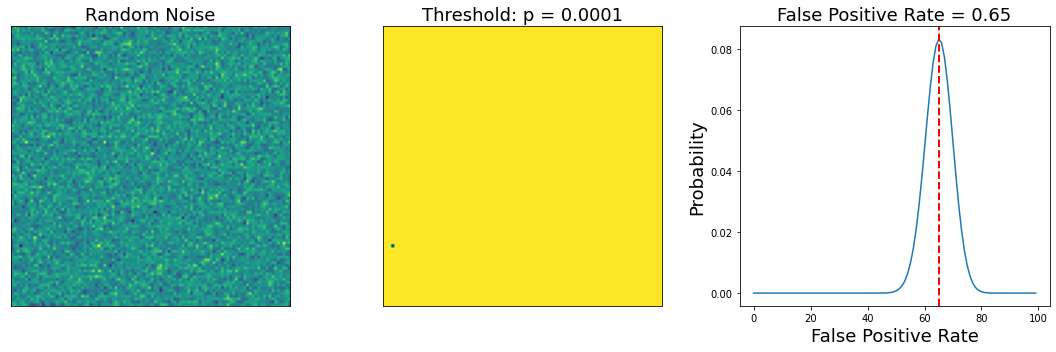

In [9]:
threshold = 0.0001
simulation = SimulateGrid(grid_width=100, n_subjects=20)
simulation.plot_grid_simulation(threshold=threshold, threshold_type='p', n_simulations=100)

You can see that this dramatically decreases the number of false positives to the point that some of the simulations no longer contain any false positives. This ultimately affects the false positive rate similarly to when we dramatically reduced the number of voxels in the previous example.

So what is the optimal threshold that will give us a false positive rate just under $\alpha=0.05$?

To calculate this, we will run 100 simulations at different threshold levels to find the threshold that leads to a false positive rate that is lower than our alpha value.

We could search over t-values, or p-values. Let's explore t-values first.

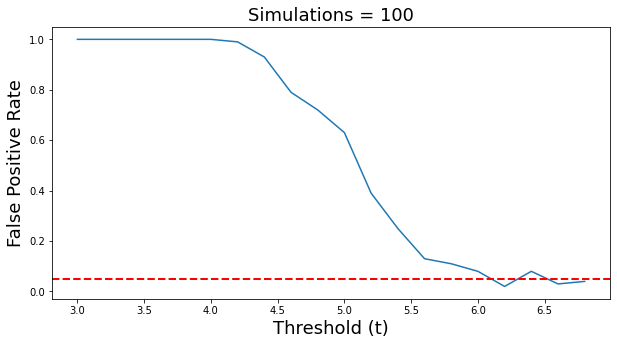

In [10]:
alpha = 0.05
n_simulations = 100
x = np.arange(3, 7, .2)

sim_all = []
for p in x:
    sim = SimulateGrid(grid_width=100, n_subjects=20)
    sim.run_multiple_simulations(threshold=p, threshold_type='t', n_simulations=n_simulations)
    sim_all.append(sim.fpr)

f,a = plt.subplots(ncols=1, figsize=(10, 5))
a.plot(x, np.array(sim_all))
a.set_ylabel('False Positive Rate', fontsize=18)
a.set_xlabel('Threshold (t)', fontsize=18)
a.set_title(f'Simulations = {n_simulations}', fontsize=18)
a.axhline(y=alpha, color='r', linestyle='dashed', linewidth=2)

As you can see, the false positive rate is close to our alpha starting at a threshold of about 6.2. This means that when we test a hypothesis over 10,000 independent voxels, we can be confident that we will only observe false positives in approximately 5 out of 100 experiments. This means that we are effectively controlling the family wise error rate (FWER). 

Let's use that threshold for our simulation again.

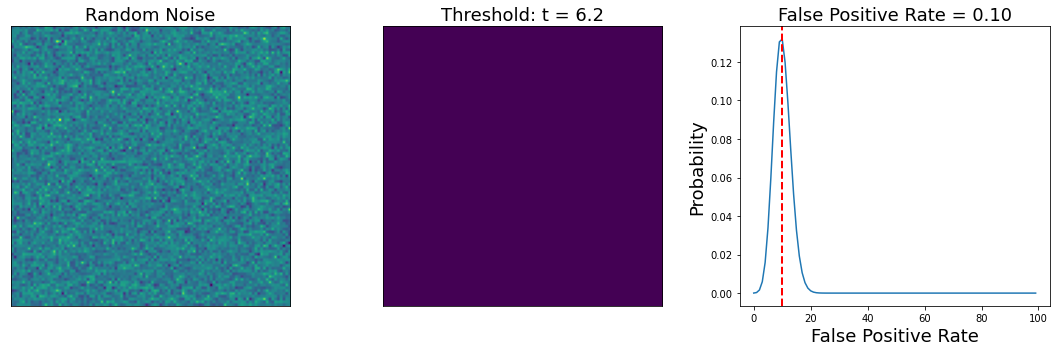

In [11]:
simulation = SimulateGrid(grid_width=100, n_subjects=20)
simulation.plot_grid_simulation(threshold=6.2, threshold_type='t', n_simulations=100)

Notice, that we are now observing a false positive rate of approximately .05, though this number will slightly change each time you run the simulation.

Another way to find the threshold that controls FWER is to divide the alpha by the number of independent tests across voxels. This is called the **bonferroni correction**.

${bonferroni} = \frac{\alpha}{M}$, where $M$ is the number of voxels.

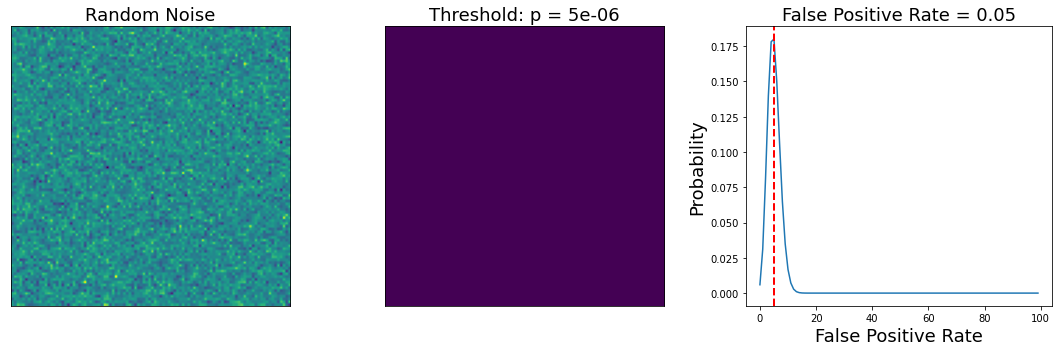

In [12]:
grid_width = 100
threshold = 0.05/(grid_width**2)
simulation = SimulateGrid(grid_width=grid_width, n_subjects=20)
simulation.plot_grid_simulation(threshold=threshold, threshold_type='p', n_simulations=100)

This seems like a great way to ensure that we minimize our false positives.

Now what happens when start adding signal to our simulation?

We will represent signal in a smaller square in the middle of the simulation. The width of the square can be changed using the `signal_width` parameter. The amplitude of this signal is controlled by the `signal_amplitude` parameter.

Let's see how well the bonferroni threshold performs when we add 100 voxels of signal.

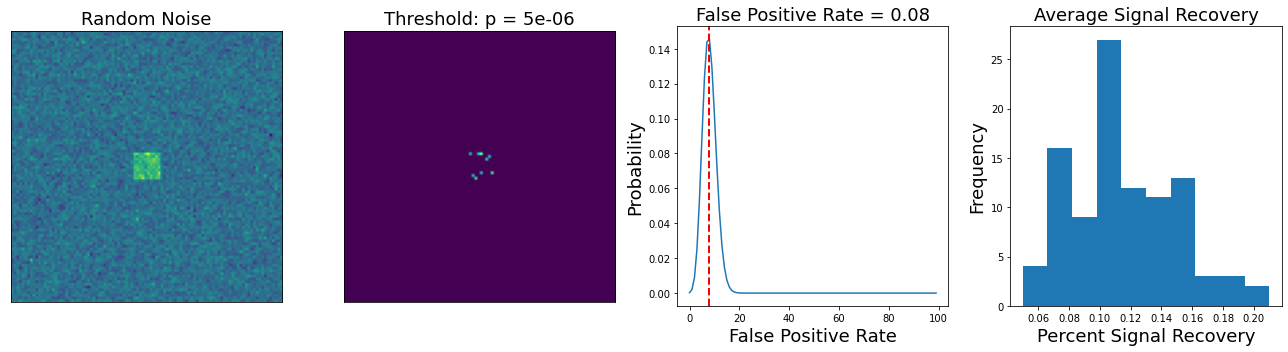

In [13]:
grid_width = 100
threshold = .05/(grid_width**2)
signal_width = 10
signal_amplitude = 1

simulation = SimulateGrid(signal_amplitude=signal_amplitude, signal_width=10, grid_width=grid_width, n_subjects=20)
simulation.plot_grid_simulation(threshold=threshold, threshold_type='p', n_simulations=100)

Here we show how many voxels were identified using the bonferroni correction. 

In the left panel is the average data across all 20 participants in an example experiment. The second panel, shows the voxels that exceed the statistical threshold in that experiment. The third panel shows the false positive rate, and the 4th panel furthest to the right shows the average signal recovery (how many voxels survived within the true signal square across all 100 simulations).

We can see that we have an effective false positive rate approximately equal to our alpha threshold. However, our threshold is so high, that we can barely detect any true signal with this amplitude. In fact, we are only recovering about 12% of the voxels that should have signal!

This simulation highlights the main issue with using bonferroni correction in practice. The threshold is so conservative that the magnitude of an effect needs to be unreasonably large to survive correction over hundreds of thousands of voxels.


## Family Wise Error Rate

At this point you may be wondering if it even makes sense to assume that each test is independent. It seems reasonable to expect some degree of spatial correlation in our data. Our simulation is a good example of this as we have a square that contains signal across contiguous voxels. In practice, most of our functional neuroanatomy that we are investigating is larger than a single voxel and our spatial smoothing preprocessing step increase the spatial correlation.

It can be shown that the Bonferroni correction is overally conservative in the presence of spatial dependence and results in a decreased power to detect voxels that are truly active.

Let's watch a video by Martin Lindquist to learn more about different ways to control for the Family Wise Error Rate.

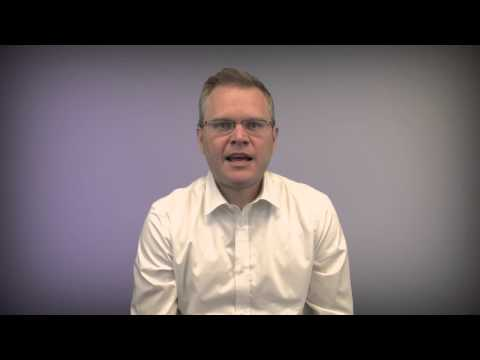

In [14]:
YouTubeVideo('MxQeEdVNihg')

### Cluster Extent

Another approach to controlling the FWER is called cluster correction, or cluster extent. In this approach, the goal is to identify a threshold such that the maximum statistic exceeds it at a specified alpha. The distribution of the maximum statistic can be approximated using Gaussian Random Field Theory (RFT), which attempts to account for the spatial dependence of the data.  

![fwer.png](../images/thresholding/fwer.png)

This requires specifying an initial threshold to determine the *Euler Characteristic* or the number of blobs minus the number of holes in the thresholded image. The number of voxels in the blob and the overall smoothness can be used to calculate something called *resels* or resolution elements and can be effectively thought of as the spatial units that need to be controlled for using FWER. We won't be going into too much detail with this approach as the mathematical details are somewhat complicated. In practice, if the image is smooth and the number of subjects is high enough (around 20), cluster correction seems to provide control closer to the true false positive rate than Bonferroni correction. Though we won't be spending time simulating this today, I encourage you to check out this Python [simulation](https://matthew-brett.github.io/teaching/random_fields.html) by Matthew Brett and this [chapter](https://www.fil.ion.ucl.ac.uk/spm/doc/books/hbf2/pdfs/Ch14.pdf) for an introduction to random field theory.

![grf.png](../images/thresholding/grf.png)

Cluster extent thresholding has recently become somewhat controversial due to several high profile papers that have found that it appears to lead to an inflated false positive rate in practice (see [Ekland et al., 2017](https://www.pnas.org/content/113/28/7900)). A recent paper by [Woo et al. 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4214144/) has shown that a liberal initial threshold (i.e. higher than p < 0.001) will inflate the number of false positives above the nominal level of 5%. There is no optimal way to select the initial threshold and often slight changes will give very different results. Furthermore, this approach does not appear to work equally well across all types of findings. For example, this approach can work well with some amounts of smoothing results that have a particular spatial extent, but not equally well for all types of signals. In other words, it seems potentially problematic to assume that spatial smoothness is constant over the brain and also that it is adequately represented using a Gaussian distribution. Finally, it is important to note that this approach only allows us to make inferences for the entire cluster. We can say that there is some voxel in the cluster that is significant, but we can't really pinpoint which voxels within the cluster may be driving the effect.

This is one of the more popular ways to control for multiple comparisons as it is particularly sensitive when there is a weak, but spatially contiguous signal. However, in practice, we don't recommend using this approach as it has a lot of assumptions that are rarely met and the spatial inference is fairly weak.

There are several other popular FWER approaches to correcting for multiple tests that try to address these issues.

### Threshold Free Cluster Extent
One interesting solution to the issue of finding an initial threshold seems to be addressed by the threshold free cluster enhancement method presented in [Smith & Nichols, 2009](https://www.sciencedirect.com/science/article/pii/S1053811908002978?via%3Dihub). In this approach, the authors propose a way to combine cluster extent and voxel height into a single metric that does not require specifying a specific initial threshold. It essentially involves calculating the integral of the overall product of a signal intensity and spatial extent over multiple thresholds. It has been shown to perform particularly well when combined with non-parameteric resampling approaches such as [randomise](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Randomise/UserGuide) in FSL. This method is implemented in FSL and also in [Matlab](https://github.com/markallenthornton/MatlabTFCE) by Mark Thornton. For more details about this approach check out this [blog post](http://markallenthornton.com/blog/matlab-tfce/) by Mark Thornton, this [video](https://mumfordbrainstats.tumblr.com/post/130127249926/paper-overview-threshold-free-cluster-enhancement) by Jeanette Mumford, and the original [technical report](https://www.fmrib.ox.ac.uk/datasets/techrep/tr08ss1/tr08ss1.pdf).

### Parametric simulations
One approach to estimating the inherent smoothness in the data, or it's spatial autocorrelation, is using parametric simulations. This was the approach originally adopted in AFNI's AlphaSim/3DClustSim. After it was [demonstrated](https://www.pnas.org/content/113/28/7900) that real fMRI data was not adequately modeled by a standard Gaussian distribution, the AFNI group quickly updated their software and implemented a range of different algorithms in their [3DClustSim](https://afni.nimh.nih.gov/pub/dist/doc/program_help/3dClustSim.html) tool. See this [paper](https://www.biorxiv.org/content/10.1101/065862v1) for an overview of these changes.

### Nonparametric approaches
As an alternative to RFT, nonparametric methods use the data themselves to find the appropriate null distribution. These methods can provide substantial improvements in power and validity, particularly with small sample sizes, so we recommend these in general over cluster extent. These tests can verify the validity of the less computationally expensive parametric approaches. However, it is important to note that this is much more computationally expensive as 5-10k permutations need to be run at every voxel. The FSL tool [randomise](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/Randomise/UserGuide) is probably the current gold standard and there are versions that run on GPUs, such as [BROCCOLI](https://github.com/wanderine/BROCCOLI) to speed up the computation time.

Here we will run a simulation using a one-sample permutation test (i.e., sign test) on our data. We will make the grid much smaller to speed up the simulation and will decrease the number of simulations by an order of magnitude, but you will see that it is still very slow (5,000 permutations times 16 voxels times 10 experiments). This approach makes no distributional assumptions, but still requires correcting for multiple tests using either FWER or FDR approaches. Don't worry about running this cell if it is taking too long.

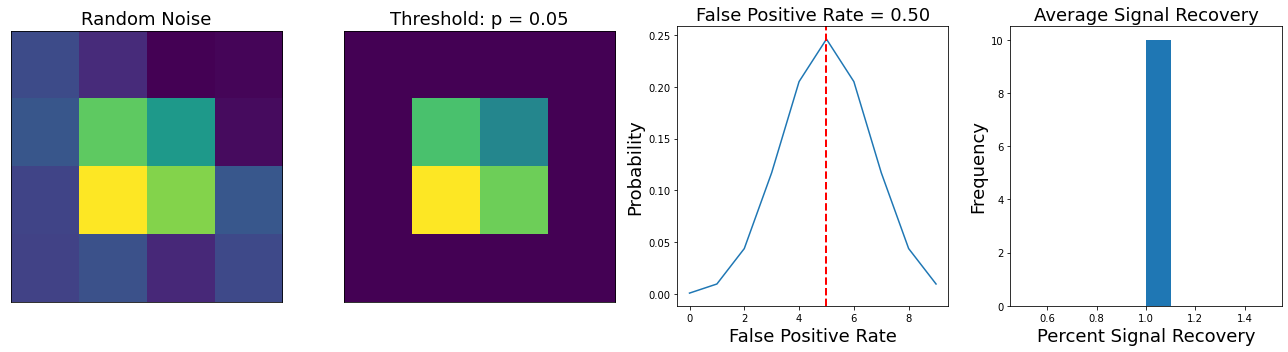

In [15]:
grid_width = 4
threshold = .05
signal_amplitude = 1
simulation = SimulateGrid(signal_amplitude=signal_amplitude, signal_width=2, grid_width=grid_width, n_subjects=20)
simulation.t_values, simulation.p_values = simulation._run_permutation(simulation.data)
simulation.isfit = True
simulation.threshold_simulation(threshold, 'p')
simulation.plot_grid_simulation(threshold=threshold, threshold_type='p', n_simulations=10)

Note that because we have reverted to using an uncorrected threshold of alpha = 0.05, the false positive rate is quite high. This highlights, as mentioned above, that permutation testing approaches stil require correction for multiple comparisons (e.g., with FWER or FDR).

## False Discovery Rate (FDR)
You may be wondering why we need to control for *any* false positive when testing across hundreds of thousands of voxels. Surely a few are okay as long as they don't overwhelm the true signal.

Let's learn about the False Discovery Rate (FDR) from another video by Martin Lindquist.

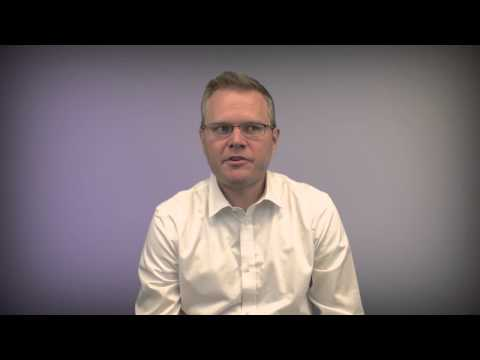

In [16]:
YouTubeVideo('W9ogBO4GEzA')

The *false discovery rate* (FDR) is a more recent development in multiple testing correction originally described by [Benjamini & Hochberg, 1995](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02031.x). While FWER is the probability of any false positives occurring in a family of tests, the FDR is the expected proportion of false positives among significant tests. 

The FDR is fairly straightforward to calculate.  
 1. We select a desired limit $q$ on FDR, which is the proportion of false positives we are okay with observing (e.g., 5/100 tests or 0.05).
 2. We rank all of the p-values over all the voxels from the smallest to largest. 
 3. We find the threshold $r$ such that $p \leq i/m * q$
 4. We reject any $H_0$ that is lower than $r$.

![image.png](../images/thresholding/fdr_calc.png)


In a brain map, this means that we expect approximately 95% of the voxels reported at q < .05 FDR-corrected to be true activations (note we use q instead of p). The FDR procedure adaptively identifies a threshold based on the overall signal across all voxels. Larger signals results in lower thresholds. Importantly, if all of the null hypotheses are true, then the FDR will be equivalent to the FWER. This means that any FWER procedure will *also* control the FDR. For these reasons, any procedure which controls the FDR is necessarily less stringent than a FWER controlling procedure, which leads to an overall increased power. Another nice feature of FDR, is that it operates on p-values instead of test statistics, which means it can be applied to most statistical tests.

This figure is taken from Poldrack, Mumford, & Nichols (2011) and compares different procedures to control for multiple tests.
![image.png](../images/thresholding/fdr.png)

For a more indepth overview of FDR, see this [tutorial](https://matthew-brett.github.io/teaching/fdr.html) by Matthew Brett.

Let's now try to apply FDR to our own simulations. All we need to do is add a `correction='fdr'` flag to our simulation plot. We need to make sure that the `threshold=0.05` to use the correct $q$.

FDR q < 0.05 corresponds to p-value of 0.00027635674179601096


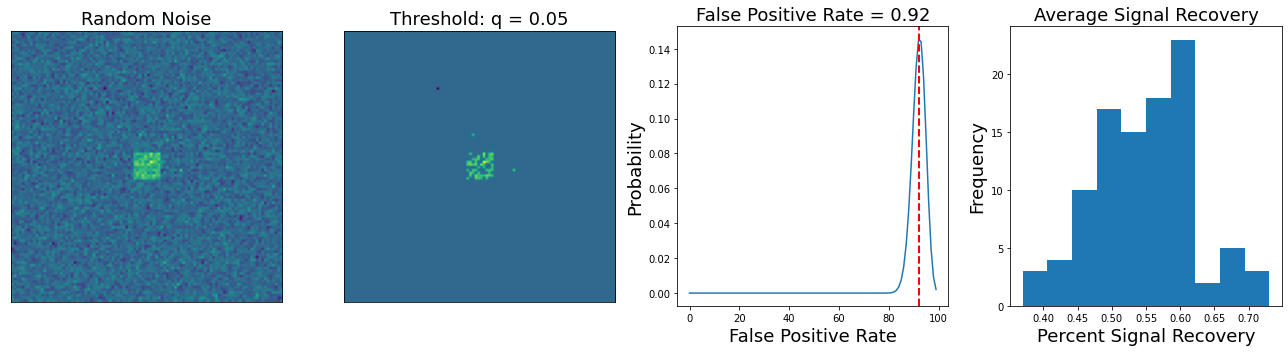

In [17]:
grid_width = 100
threshold = .05
signal_amplitude = 1
simulation = SimulateGrid(signal_amplitude=signal_amplitude, signal_width=10, grid_width=grid_width, n_subjects=20)
simulation.plot_grid_simulation(threshold=threshold, threshold_type='q', n_simulations=100, correction='fdr')
print(f'FDR q < 0.05 corresponds to p-value of {simulation.corrected_threshold}')

Okay, using FDR of q < 0.05 for our simulation identifies a p-value threshold of p < 0.00034. This is more liberal than the bonferroni threshold of p < 0.000005 and allows us to recover much more signal as a consequence. You can see that at this threshold there are more false positives, which leads to a much higher overall false positive rate. Remember, this metric is only used for calculating the family wise error rate and indicates the presence of *any* false positive across each of our 100 experiments.

To calculate the empirical false discovery rate, we need to calculate the proportion of false positives among voxels that were labeled active (those that were under the p-value threshold).

Text(0.5, 0, 'False Discovery Rate of Simulations')

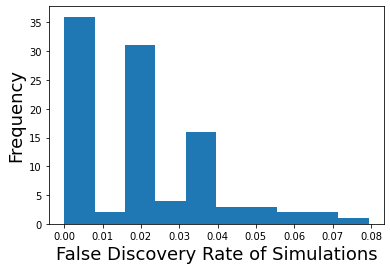

In [18]:
plt.hist(simulation.multiple_fdr)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('False Discovery Rate', fontsize=18)
plt.xlabel('False Discovery Rate of Simulations', fontsize=18)

In our 100 simulations, the majority had a false discovery rate below our q < 0.05.

### Thresholding Brain Maps

In the remainder of the tutorial, we will move from simulation to playing with real data. 

Let's watch another video by Tor Wager on how multiple comparison approaches are used in practice, highlighting some of the pitfalls with some of the different approaches.

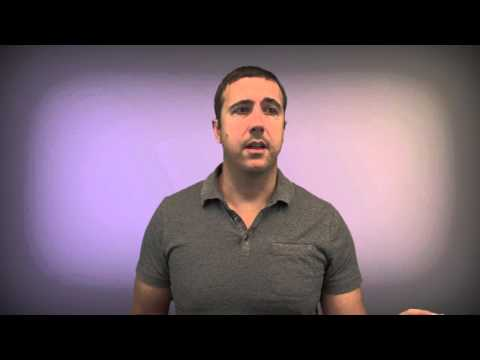

In [21]:
YouTubeVideo('N7Iittt8HrU')

We will be exploring two simple and fast ways to threshold your group analyses.

First, we will simply threshold based on selecting an arbitrary statistical threshold. The values are completely arbitrary, but it is common to start with something like p < .001. We call this *uncorrected* because this is simply the threshold for any voxel as we are not controlling for multiple tests.

In [20]:
con1_name = 'horizontal_checkerboard'
data_dir = '../data/localizer'
con1_file_list = glob.glob(os.path.join(data_dir, 'derivatives','fmriprep','*', 'func', f'sub*_{con1_name}*nii.gz'))
con1_file_list.sort()
con1_dat = Brain_Data(con1_file_list)
con1_stats = con1_dat.ttest(threshold_dict={'unc':.001})

con1_stats['thr_t'].plot()

IndexError: list index out of range

We see some significant activations in visual cortex, but we also see strong t-tests in the auditory cortex.

Why do you think this is?



We can also easily run FDR correction by changing the inputs of the `threshold_dict`. We will be using a q value of 0.05 to control our false discovery rate.

In [ ]:
con1_stats = con1_dat.ttest(threshold_dict={'fdr':.05})
con1_stats['thr_t'].plot()

You can see that at least for this particular contrast, the FDR threshold appears to be more liberal than p < 0.001 uncorrected.

Let's look at another contrast between vertical and horizontal checkerboards.

In [ ]:
con2_name = 'vertical_checkerboard'
con2_file_list = glob.glob(os.path.join(data_dir, 'derivatives','fmriprep','*', 'func', f'sub*_{con2_name}*nii.gz'))
con2_file_list.sort()
con2_dat = Brain_Data(con2_file_list)

con1_v_con2 = con1_dat-con2_dat

con1_v_con2_stats = con1_v_con2.ttest(threshold_dict={'unc':.001})
con1_v_con2_stats['thr_t'].plot()

In [ ]:
con1_v_con2_stats = con1_v_con2.ttest(threshold_dict={'fdr':.05})
con1_v_con2_stats['thr_t'].plot()

Looks like there are some significant differences that survive in early visual cortex and also in other regions of the brain.

This concludes are very quick overview to performing univariate analyses in fMRI data analysis.

We will continue to add more advanced tutorials to the dartbrains.org website. Stay tuned!

## Exercises

### Exercise 1. Bonferroni Correction Simulation
Using the Grid Simulation code above, try to find how much larger the signal needs to be using a Bonferroni Correction until we can recover 100% of the true signal, while controlling a family wise error false-positive rate of p < 0.05.

### Exercise 2. Which regions are more involved with visual compared to auditory sensory processing?
 - run a group level t-test and threshold using an uncorrected voxel-wise threshold of p < 0.05, p < 0.005, and p < 0.001.
 - plot each of the results
 - write each file to your output folder.


### Exercise 3. Which regions are more involved in processing numbers compared to words?
 - run a group level t-test, using a correcte FDR threshold of q < 0.05.
 - plot the results
 - write the file to your output folder.
